## model using
### begin from this(read data which had been saved)

In [1]:
import numpy as np
import pandas as pd
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
import matplotlib.pyplot as plt


from tqdm import tqdm
from io import StringIO
from contextlib import redirect_stdout
import logging
logging.getLogger('implied_vol_solver').setLevel(logging.WARNING)  # 只显示警告和错误
from tqdm import tqdm

from implied_vol_solver import CDSImpliedVolatilitySolver, CDSQuoteType
from options_optimizer import EquityOption, OptionType, EQ_OPTION_PRICING_FACTOR
from stock_pnl_calc import calculate_pnl_w_static_stock_price_map, TradeType

### Some Constants

In [2]:
stock_px_col = 'close'

---

### Specify Data Range - define `min_stk_px` and `max_stk_px` as their counterparts in the lookback period

In [3]:
start_date = '2024-11-18'
end_date = '2024-12-31'
lookback_period_months = 3
lookback_stk_px_buffer = 0.2

In [4]:
start_date = pd.to_datetime(start_date)
lookback_start_date = start_date - pd.DateOffset(months=lookback_period_months)
start_date = start_date.date()
lookback_start_date = lookback_start_date.date()
end_date = pd.to_datetime(end_date).date()

In [5]:
stock_data_all = pd.read_parquet('opt_stock_data/stock_data_XRX_minute.parquet')

In [6]:
# in practice, min_stk_px and max_stk_px are chosen based on liquidity of hedging options, expected range of stock movement, among other things: keeping it simple for now
stock_data_lookback = stock_data_all[(stock_data_all.date >= lookback_start_date) & (stock_data_all.date < start_date)]
min_stk_px = stock_data_lookback[stock_px_col].min() * (1 - lookback_stk_px_buffer)
max_stk_px = stock_data_lookback[stock_px_col].max() * (1 + lookback_stk_px_buffer)

---

### CGM stuff - Implied vol and generateing stock table as of `start_date`, and keep it fixed through the period

In [7]:
cgm_df = pd.read_csv('res/input_data.csv', index_col='date', parse_dates=['date'])
cgm_df.index = cgm_df.index.date
cgm_df = cgm_df.loc[[start_date]]

In [8]:
# implied vol calculation
# S = 100.0        # stock price
# D = 150.0        # debt per share
t = 5.0          # CDS tenor
r = 0.05         # risk free rate
R = 0.4          # recovery rate
L = 0.5          # loss given default
lamb = 0.3       # barrier deviation
notional = -1_000_000  # negative for sell CDS protection/buy stock      
# cds_coupon = 0.01 # not needed

In [9]:
# create new columns
cgm_df['implied_vol'] = np.nan 
cgm_df['par_spread_error'] = np.nan
solver = CDSImpliedVolatilitySolver(t, r, L, lamb, CDSQuoteType.UPFRONT)

with redirect_stdout(StringIO()):
    for i, row in tqdm(cgm_df.iterrows()):
        # imply vol by CDS upfront
        market_cds_upfront = row['upfront']
        cds_coupon = row['runningcoupon']
        R = row['cdsassumedrecovery']
        D = row['financial_debt_ratio']
        S = row['stock_price']
        implied_vol, error = solver.solve_implied_volatility(S, D, market_cds_upfront, cds_coupon, R, method='brent')
        cgm_df.at[i, 'implied_vol'] = implied_vol
        cgm_df.at[i, 'par_spread_error'] = error

1it [00:00, 185.45it/s]


In [10]:
from generate_daily_hedge_maps import generate_daily_stock_share_maps

# 使用已有的df(output_data.csv)
stock_share_maps = generate_daily_stock_share_maps(
    cgm_df, 
    t=t, 
    r=r, 
    L=L, 
    lamb=lamb, 
    notional = notional, # negative for sell CDS protection/buy stock
    min_price = min_stk_px,
    max_price = max_stk_px,
    output_dir='res/hedge_maps'
)


Generating hedge maps: 100%|██████████| 1/1 [00:00<00:00, 23.42it/s]


In [11]:
# There should only be one map as of start_date
stock_share_map = list(stock_share_maps.values())[-1]

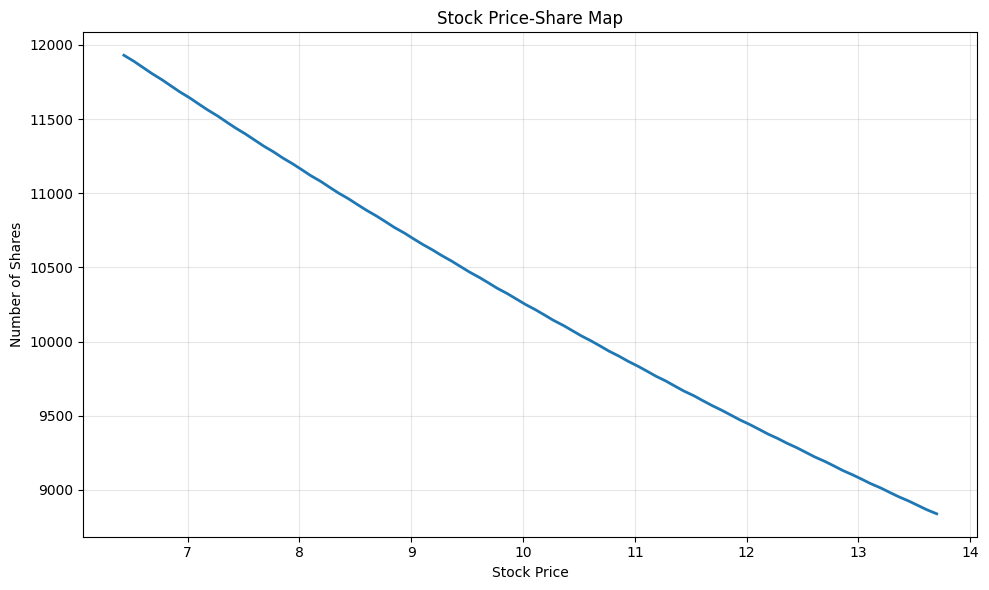

In [12]:
# Plot the hedge map
from IPython.display import display

fig, ax = plt.subplots(figsize=(10, 6))
prices = list(stock_share_map.keys())
shares = list(stock_share_map.values())
ax.plot(prices, shares, linewidth=2)
ax.set_xlabel('Stock Price')
ax.set_ylabel('Number of Shares')
ax.set_title('Stock Price-Share Map')
ax.grid(True, alpha=0.3)
plt.tight_layout()
display(fig)
plt.close()


### Stock pnl calculation

In [13]:
# Filter stock data for the analysis period
stock_data = stock_data_all[
    (stock_data_all['date'] >= start_date) & 
    (stock_data_all['date'] <= end_date)
]
res = calculate_pnl_w_static_stock_price_map(stock_data, stock_share_map)

In [14]:
print(f"Total Cash Flow: {res['total_cash_flow']:.2f}")
print(f"Total Transaction Cost: {res['total_transaction_cost']:.2f}")
print(f"Total PnL: {res['total_pnl']:.2f}")


Total Cash Flow: 937.27
Total Transaction Cost: 276.11
Total PnL: 661.16


### Breaking down profits and costs

In [15]:
# Display trade log as DataFrame
trade_log_df = pd.DataFrame(res['trade_log'])
# Create timestamp column by combining date and time
trade_log_df['timestamp'] = pd.to_datetime(trade_log_df['date'].astype(str) + ' ' + trade_log_df['time'].astype(str))

### Rebalancing cashflow and transaction cost

C:\Users\zhong\AppData\Local\Temp\ipykernel_19536\1831560897.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rebalancing_df['cumulative_transaction_cost'] = rebalancing_df['transaction_cost'].cumsum()
C:\Users\zhong\AppData\Local\Temp\ipykernel_19536\1831560897.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rebalancing_df['cumulative_cash_flow'] = rebalancing_df['cash_flow'].cumsum()
C:\Users\zhong\AppData\Local\Temp\ipykernel_19536\1831560897.py:8: SettingWithCopyWarning: 
A value is trying to be 

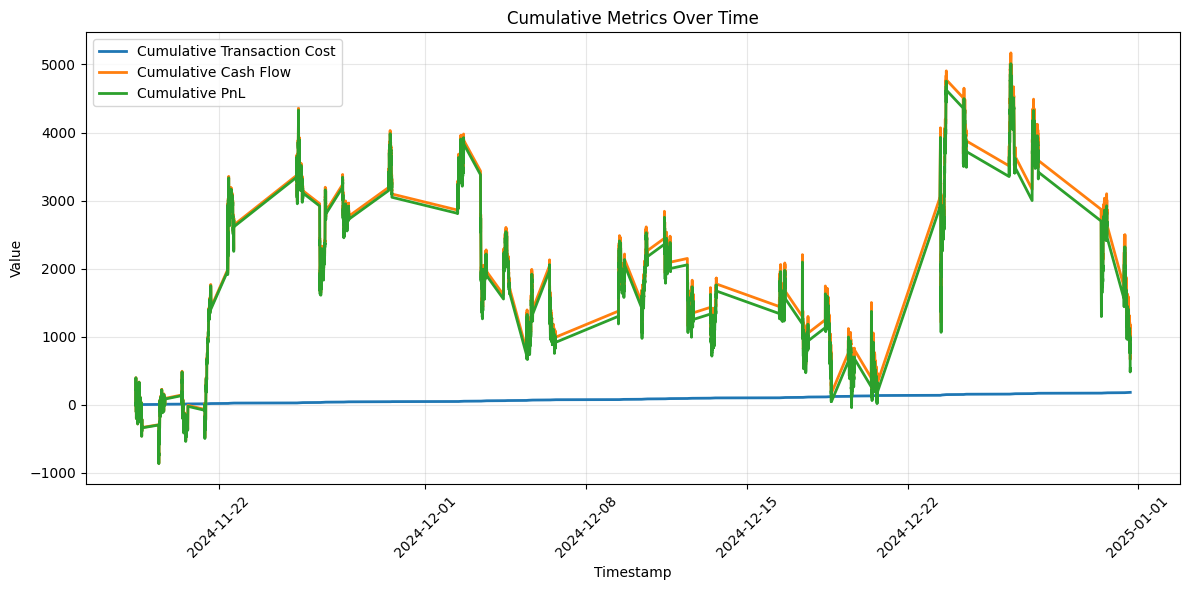

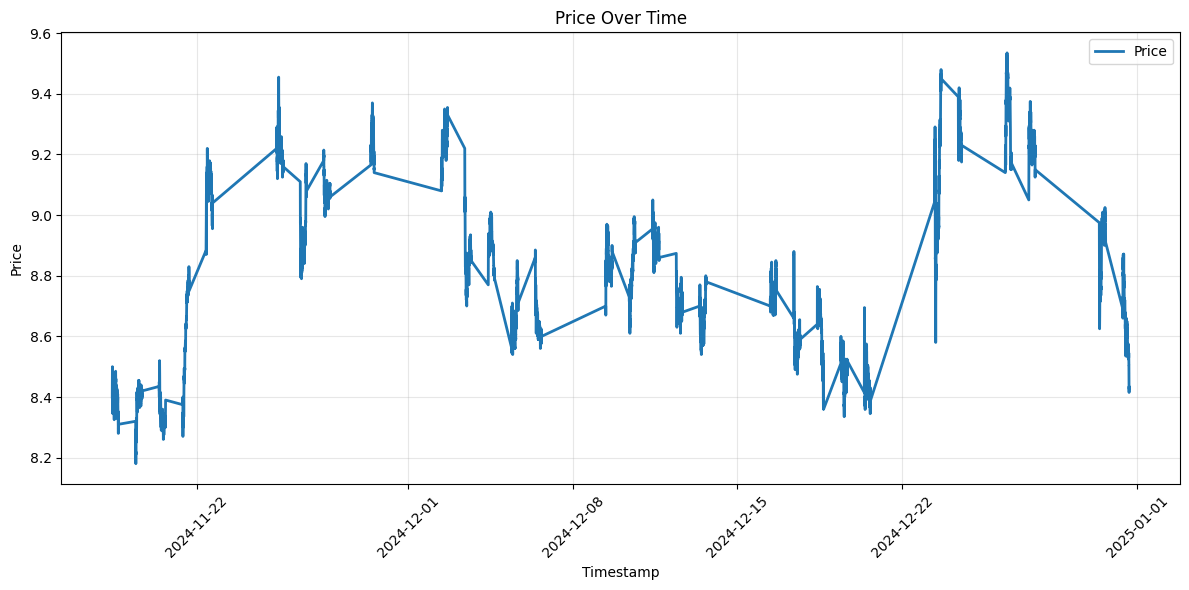

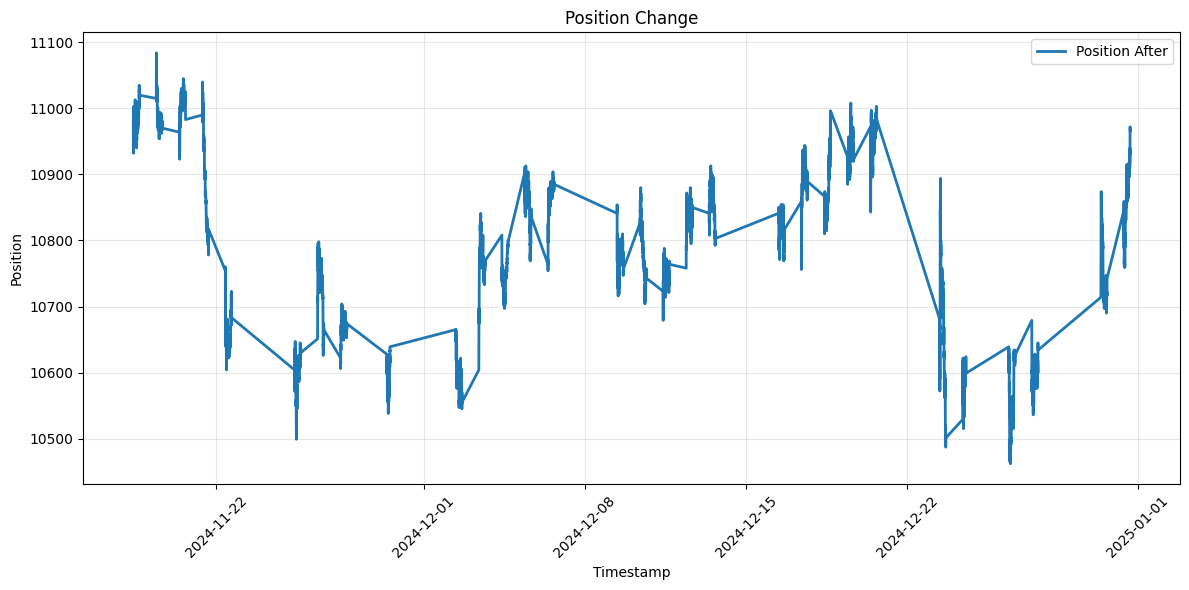

In [16]:
# Filter for rebalancing trades only (exclude initial_position and close_position)
rebalancing_df = trade_log_df[~trade_log_df['trade_type'].isin({TradeType.INITIAL_POSITION, TradeType.CLOSE_POSITION})]

# Compute cumulative columns from the filtered rebalancing data
rebalancing_df['cumulative_transaction_cost'] = rebalancing_df['transaction_cost'].cumsum()
rebalancing_df['cumulative_cash_flow'] = rebalancing_df['cash_flow'].cumsum()
# Note that the convention in cashflow is positive/negative for gain/loss, while transaction cost is the absolute value
rebalancing_df['cumulative_pnl'] = rebalancing_df['cumulative_cash_flow'] - rebalancing_df['cumulative_transaction_cost']

# Plot the three cumulative columns
plt.figure(figsize=(12, 6))
plt.plot(rebalancing_df['timestamp'], rebalancing_df['cumulative_transaction_cost'], label='Cumulative Transaction Cost', linewidth=2)
plt.plot(rebalancing_df['timestamp'], rebalancing_df['cumulative_cash_flow'], label='Cumulative Cash Flow', linewidth=2)
plt.plot(rebalancing_df['timestamp'], rebalancing_df['cumulative_pnl'], label='Cumulative PnL', linewidth=2)
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.title('Cumulative Metrics Over Time')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(rebalancing_df['timestamp'], rebalancing_df['price'], label='Price', linewidth=2)
plt.xlabel('Timestamp')
plt.ylabel('Price')
plt.title('Price Over Time')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(rebalancing_df['timestamp'], rebalancing_df['position_after'], label='Position After', linewidth=2)
plt.xlabel('Timestamp')
plt.ylabel('Position')
plt.title('Position Change')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

---

### Options Stuff - we will refine this later

### Choosing the hedging OTM put option

In [17]:
# Read the options data from CSV file
options_df = pd.read_csv('opt_stock_data/opt_data_XRX.csv')

# massage data
options_df['date'] = pd.to_datetime(options_df['date'])
options_df = options_df.sort_values('date')
options_df['expiration_date'] = pd.to_datetime(options_df['expiration_date'])
options_df['expiry_in_years'] = (options_df['expiration_date'] - options_df['date']).dt.days / 365.25
options_df['expiration_date'] = options_df['expiration_date'].dt.date
options_df['date'] = options_df['date'].dt.date

options_df['stock_price'] = options_df['und_day_close']
options_df['option_price'] = options_df['day_close']
options_df['implied_vol'] = options_df['iv']


In [18]:
options_df = options_df.loc[(options_df.date == start_date)&(options_df.option_type.str.upper()=='P')]
options_df

,date,und_ticker,ticker,option_type,strike_price,expiration_date,day_open,day_high,day_low,day_close,...,iv,delta,gamma,vega,theta,open_interest,expiry_in_years,stock_price,option_price,implied_vol
27936,2024-11-18,XRX,O:XRX250117P00020000,P,20,2025-01-17,11.72,11.76,11.72,11.76,...,1.156096,-0.949431,0.026718,0.003506,-0.003378,435.0,0.164271,8.31,11.76,1.156096
27935,2024-11-18,XRX,O:XRX250117P00009000,P,9,2025-01-17,1.10,1.10,1.10,1.10,...,0.502362,-0.614008,0.226010,0.012889,-0.005396,2712.0,0.164271,8.31,1.10,0.502362
27934,2024-11-18,XRX,O:XRX250117P00008000,P,8,2025-01-17,0.60,0.60,0.60,0.60,...,0.565925,-0.389579,0.201162,0.012923,-0.006095,14472.0,0.164271,8.31,0.60,0.565925
27933,2024-11-18,XRX,O:XRX250117P00007000,P,7,2025-01-17,0.25,0.25,0.25,0.25,...,0.587716,-0.200714,0.141687,0.009453,-0.004630,22913.0,0.164271,8.31,0.25,0.587716
27925,2024-11-18,XRX,O:XRX241220P00008000,P,8,2024-12-20,0.35,0.35,0.30,0.35,...,0.508647,-0.371556,0.302093,0.009303,-0.007394,334.0,0.087611,8.31,0.35,0.508647
27924,2024-11-18,XRX,O:XRX241220P00007000,P,7,2024-12-20,0.11,0.14,0.10,0.10,...,0.563064,-0.132998,0.155114,0.005288,-0.004652,213.0,0.087611,8.31,0.10,0.563064


### Check if the BS delta calc is working - bs_delta should be close to delta: see abs_delta_diff_check

In [19]:
def calculate_bs_delta_for_row(row):
    """Calculate Black-Scholes delta for a single row of options data."""
    assert row['option_type'].upper() in {'C', 'P'}, "Invalid option type"
    option_type = OptionType.CALL if row['option_type'].upper() == 'C' else OptionType.PUT
    
    # Create EquityOption instance
    option = EquityOption(
        strike=row['strike_price'],
        expiry_in_years=row['expiry_in_years'],
        option_type=option_type,
        implied_vol=row['implied_vol'],
        option_price=row['option_price']
    )
    
    # Calculate Black-Scholes delta using the stock price from the row
    bs_delta = option.calculate_bs_delta(stock_price=row['stock_price'], interest_rate=0.0)
    return bs_delta

# Add bs_delta column to the options dataframe
options_df['bs_delta'] = options_df.apply(calculate_bs_delta_for_row, axis=1)
options_df['abs_delta_diff_check'] = abs(options_df['bs_delta'] - options_df['delta'])

In [20]:
options_df.sort_values('strike_price')

,date,und_ticker,ticker,option_type,strike_price,expiration_date,day_open,day_high,day_low,day_close,...,gamma,vega,theta,open_interest,expiry_in_years,stock_price,option_price,implied_vol,bs_delta,abs_delta_diff_check
27933,2024-11-18,XRX,O:XRX250117P00007000,P,7,2025-01-17,0.25,0.25,0.25,0.25,...,0.141687,0.009453,-0.004630,22913.0,0.164271,8.31,0.25,0.587716,-0.200656,0.000058
27924,2024-11-18,XRX,O:XRX241220P00007000,P,7,2024-12-20,0.11,0.14,0.10,0.10,...,0.155114,0.005288,-0.004652,213.0,0.087611,8.31,0.10,0.563064,-0.132928,0.000070
27925,2024-11-18,XRX,O:XRX241220P00008000,P,8,2024-12-20,0.35,0.35,0.30,0.35,...,0.302093,0.009303,-0.007394,334.0,0.087611,8.31,0.35,0.508647,-0.371533,0.000023
27934,2024-11-18,XRX,O:XRX250117P00008000,P,8,2025-01-17,0.60,0.60,0.60,0.60,...,0.201162,0.012923,-0.006095,14472.0,0.164271,8.31,0.60,0.565925,-0.389572,0.000007
27935,2024-11-18,XRX,O:XRX250117P00009000,P,9,2025-01-17,1.10,1.10,1.10,1.10,...,0.226010,0.012889,-0.005396,2712.0,0.164271,8.31,1.10,0.502362,-0.614073,0.000065
27936,2024-11-18,XRX,O:XRX250117P00020000,P,20,2025-01-17,11.72,11.76,11.72,11.76,...,0.026718,0.003506,-0.003378,435.0,0.164271,8.31,11.76,1.156096,-0.949506,0.000075


### Manually choose the most OTM and longest tenor option available, for illustrations

In [21]:
idx = 3
chosen_option = options_df.iloc[idx]

In [22]:
min_stk_shares = stock_share_map[min(stock_share_map)]

option_type = OptionType.CALL if chosen_option['option_type'].upper() == 'C' else OptionType.PUT
# Create EquityOption instance
option = EquityOption(
    strike=chosen_option['strike_price'],
    expiry_in_years=chosen_option['expiry_in_years'],
    option_type=option_type,
    implied_vol=chosen_option['implied_vol'],
    option_price=chosen_option['option_price']
)
num_contracts = abs(int(min_stk_shares / (option.calculate_bs_delta() * EQ_OPTION_PRICING_FACTOR)))
option.set_number_contracts(num_contracts)
equiv_stk_shares = option.equivalent_stock_shares(stock_price_grids=stock_share_map.keys())
# equiv_stk_shares

In [23]:
net_stk_shares = {k: stock_share_map[k] + equiv_stk_shares[k] for k in stock_share_map.keys()}
# net_stk_shares

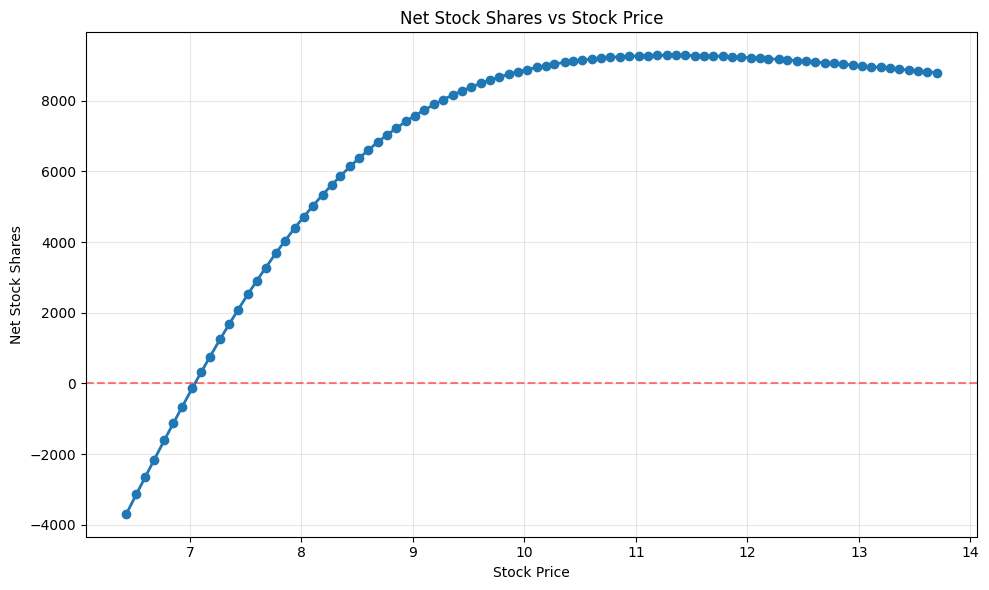

In [24]:

# Plot the net stock shares
plt.figure(figsize=(10, 6))
plt.plot(list(net_stk_shares.keys()), list(net_stk_shares.values()), marker='o', linestyle='-', linewidth=2)
plt.xlabel('Stock Price')
plt.ylabel('Net Stock Shares')
plt.title('Net Stock Shares vs Stock Price')
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
